# Learning and Decision Making

## Laboratory 4: Partially observable Markov decision problems

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. Modeling

Consider once again the guessing game domain described in the Homework and which you described as a POMDP.

Recall that:

* The opponent can hold one of two cards in hand: an Ace of Clubs (A&clubs;) and an Ace of Diamonds (A&diams;). The agent must guess which card the opponent is holding. 

* For every right answer, the agent wins 1EUR, and every wrong answer costs the agent 1EUR. 

* The agent can also try to _peek_. 

* When the agent peeks, it sees the right card with a probability of 0.9 and the wrong card with probability 0.1.

* The game restarts whenever the agent makes a guess.

Consider throughout that $\gamma=0.9$.

---

#### Activity 1.        

Implement your POMDP in Python. In particular,

* Create a list with all the states;
* Create a list with all the actions;
* Create a list with all the observations
* For each action, define a `numpy` array with the corresponding transition probabilities;
* For each action, define a `numpy` array with the corresponding observation probabilities;
* Define a `numpy`array with the cost that you defined in your homework.

The order for the states and actions used in the transition probability and cost matrices should match that in the lists of states and actions. 

**Note**: Don't forget to import `numpy`.

---

In [2]:
import numpy as np

stateSpace = ["AC", "AD"]
print(stateSpace, "\n\n")

actionSpace = ["guessAC", "guessAD", "peek"]
print(actionSpace, "\n\n")

observationSpace = ["sawAC", "sawAD"]
print(observationSpace, "\n\n")

pGuessAC = np.array([[0.5, 0.5], 
                     [0.5, 0.5]])
print(pGuessAC, "\n\n")

pGuessAD = np.array([[0.5, 0.5], 
                     [0.5, 0.5]])
print(pGuessAD, "\n\n")

pPeek = np.array([[1, 0], 
                  [0, 1]])
print(pPeek, "\n\n")

pObsGuessAC = np.array([[0.5, 0.5], 
                        [0.5, 0.5]])
print(pObsGuessAC, "\n\n")

pObsGuessAD = np.array([[0.5, 0.5], 
                        [0.5, 0.5]])
print(pObsGuessAD, "\n\n")

pObsPeek = np.array([[0.9, 0.1], 
                     [0.1, 0.9]])
print(pObsPeek, "\n\n")

costFunc = np.array([[0, 1, 0.1], 
                     [1, 0, 0.1]])
print(costFunc)

['AC', 'AD'] 


['guessAC', 'guessAD', 'peek'] 


['sawAC', 'sawAD'] 


[[ 0.5  0.5]
 [ 0.5  0.5]] 


[[ 0.5  0.5]
 [ 0.5  0.5]] 


[[1 0]
 [0 1]] 


[[ 0.5  0.5]
 [ 0.5  0.5]] 


[[ 0.5  0.5]
 [ 0.5  0.5]] 


[[ 0.9  0.1]
 [ 0.1  0.9]] 


[[ 0.   1.   0.1]
 [ 1.   0.   0.1]]


### 2. Sampling

You are now going to sample random trajectories of your POMDP and observe the impact it has on the corresponding belief.

---

#### Activity 2.

Generate a random POMDP trajectory using a uniformly random policy. In particular, from a random initial state $x_0$ generate:

1. A sequence of 10,000 states by selecting the actions uniformly at random;
2. The corresponding sequence of 10,000 actions;
3. The corresponding sequence of 10,000 observations.

---

In [3]:
import numpy.random as rnd

uniformPolicy = np.array([[1/3, 1/3, 1/3],
                          [1/3, 1/3, 1/3]])

uniformDistribution = np.array([1/3, 1/3, 1/3])

allMatrixes = [pGuessAC, pGuessAD, pPeek]

'''
pPi = np.zeros((np.size(stateSpace), np.size(stateSpace)))

for i in range(np.size(stateSpace)):  
    for j in range(np.size(actionSpace)):
        prob = uniformPolicy[i,j]
        probMatrixJ = allMatrixes[j]
        probLineI = probMatrixJ[i,:]        
        probLineI = np.multiply(prob, probLineI)
        pPi[i,:] += probLineI

print(pPi)        
'''

actionTrajectory = np.array([])
stateTrajectory = np.array([rnd.choice(stateSpace)])
observationTrajectory = np.array([])

def applyAction(state, action):
    next_state = ""
    next_obs = ""
    
    if (action == "peek"):
        next_state = state
        next_obs_prob = pObsPeek[stateSpace.index(state)]
        next_obs = rnd.choice(observationSpace, p=next_obs_prob)
    elif (action == "guessAC"):
        next_state = rnd.choice(stateSpace, p=pGuessAC[stateSpace.index(state)])
        next_obs_prob = pObsGuessAC[stateSpace.index(state)]
        next_obs = rnd.choice(observationSpace, p=next_obs_prob)
    else:
        next_state = rnd.choice(stateSpace, p=pGuessAD[stateSpace.index(state)])
        next_obs_prob = pObsGuessAD[stateSpace.index(state)]
        next_obs = rnd.choice(observationSpace, p=next_obs_prob)
        
    return next_state, next_obs

for j in range(10000):
        new_a = rnd.choice(actionSpace, p=uniformDistribution)
        actionTrajectory = np.append(actionTrajectory, new_a)
        new_state, new_observation = applyAction(stateTrajectory[j], new_a)
        stateTrajectory = np.append(stateTrajectory, new_state)
        observationTrajectory = np.append(observationTrajectory, np.array([new_observation]), axis=0)
        

print(stateTrajectory)
print(actionTrajectory)
print(observationTrajectory)

['AD' 'AC' 'AC' ..., 'AD' 'AD' 'AC']
['guessAD' 'peek' 'peek' ..., 'guessAD' 'guessAD' 'guessAD']
['sawAD' 'sawAC' 'sawAC' ..., 'sawAC' 'sawAD' 'sawAC']


---

#### Activity 3.

For the POMDP trajectory generated in Activity 2, compute the corresponding sequence of beliefs, assuming that the initial belief is $\mathbf{b}_0=[0.5, 0.5]$. Report the resulting beliefs, ignoring duplicate beliefs or beliefs whose distance is smaller than $10^{-4}$.

**Note 1:** You may want to define a function `belief_update` that receives a belief, an action and an observation and returns the updated belief.

**Note 2:** To compute the distance between vectors, you may find useful `numpy`'s function `linalg.norm`.


---

In [8]:
def belief_update(belief, action, observation):
    next_belief = np.array([])
    if action == "peek":
        next_belief = np.dot(belief, pPeek)
        
    elif action == "guessAC":
        next_belief = np.dot(belief, pGuessAC)
    else:
        next_belief = np.dot(belief, pGuessAD)
        
    diagonal = diagonalize(action, observation)
    next_belief = np.dot(next_belief, diagonal)
    norm_belief = next_belief / np.sum(next_belief)
    return norm_belief
        
            
def diagonalize(action, observation):
    if action == "peek":
        if observation == "sawAC":
            return np.diag(pObsPeek[:,0])
        else: #observation == sawAD
            return np.diag(pObsPeek[:,1])
    elif action == "guessAC":
        if observation == "sawAC":
            return np.diag(pObsGuessAC[:,0])
        else:
            return np.diag(pObsGuessAC[:,1])
    else: #action == guessAD
        if observation == "sawAC":
            return np.diag(pObsGuessAD[:,0])
        else:
            return np.diag(pObsGuessAD[:,1])

initial_belief = np.array([0.5, 0.5]) 
belief_sequence = np.array([initial_belief])


def assert_different(sequence, new_belief):
    e = pow(10, -4)
    for belief in sequence:
        distance = np.linalg.norm(belief - new_belief)
        if distance <= e:
            return False
    return True

    
full_belief_sequence = np.array([initial_belief])
for i in range(len(actionTrajectory) - 1):
    last_belief = full_belief_sequence[-1]
    new_belief = np.array(belief_update(last_belief, actionTrajectory[i], observationTrajectory[i+1]))
    if assert_different(belief_sequence, new_belief):
        belief_sequence = np.append(belief_sequence, [new_belief], axis = 0)
    full_belief_sequence = np.append(full_belief_sequence, [new_belief], axis = 0)

print(belief_sequence)

print("full belief sequence is: ", full_belief_sequence)

[[  5.00000000e-01   5.00000000e-01]
 [  9.00000000e-01   1.00000000e-01]
 [  9.87804878e-01   1.21951220e-02]
 [  1.00000000e-01   9.00000000e-01]
 [  1.21951220e-02   9.87804878e-01]
 [  9.98630137e-01   1.36986301e-03]
 [  9.99847607e-01   1.52392563e-04]
 [  9.99983065e-01   1.69348010e-05]
 [  1.36986301e-03   9.98630137e-01]
 [  1.52392563e-04   9.99847607e-01]
 [  1.69348010e-05   9.99983065e-01]]
full belief sequence is:  [[ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.9  0.1]
 ..., 
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]]


### 3. Solution methods

In this section you are going to compare different non-exact solution methods.

---

#### Activity 4

Compute the solution for the underlying MDP and report the corresponding optimal policy and optimal cost-to-go. 

** Note:** You may reuse code from previous labs.

---

In [9]:
bStateSpace = np.copy(belief_sequence)
bActionSpace = np.copy(actionSpace)

#computing belief transition matrices
bPGuessAC = np.zeros((belief_sequence.shape[0], belief_sequence.shape[0]))
bPGuessAD = np.copy(bPGuessAC)
bPPeek    = np.copy(bPGuessAC)

e = pow(10, -4)

for i in range(full_belief_sequence.shape[0] - 1):
    ix = np.where(e >= np.abs(bStateSpace - full_belief_sequence[i]))[0][0]
    iy = np.where(e >= np.abs(bStateSpace - full_belief_sequence[i+1]))[0][0]
   
    if (actionTrajectory[i] == "guessAC"):
        bPGuessAC[ix, iy] += 1
    elif (actionTrajectory[i] == "guessAD"):
        bPGuessAD[ix, iy] += 1
    elif (actionTrajectory[i] == "peek"):
        bPPeek[ix, iy] += 1
    else:
        print("ERROR - belief transition matrices")

#normalizing by row
rowSum    = bPGuessAC.sum(axis = 1)
bPGuessAC = bPGuessAC / rowSum[:, np.newaxis]
rowSum    = bPGuessAD.sum(axis = 1)
bPGuessAD = bPGuessAD / rowSum[:, np.newaxis]
rowSum = bPPeek.sum(axis = 1)
bPPeek = bPPeek / rowSum[:, np.newaxis]

#removing nan
bPGuessAC = np.nan_to_num(bPGuessAC)
bPGuessAD = np.nan_to_num(bPGuessAD)
bPPeek = np.nan_to_num(bPPeek)

#computing cost matrix
bCostFunc = np.zeros((bStateSpace.shape[0], bActionSpace.size))

for b in range(bStateSpace.shape[0]):
    for a in range(bActionSpace.size):
        for x in range(len(stateSpace)):
            bCostFunc[b, a] += bStateSpace[b][x] * costFunc[x, a]

#J*
bJ = np.zeros((bStateSpace.shape[0], 1))
err = 1
gama = 0.99

cAC = bCostFunc[:, 0].reshape(bStateSpace.shape[0], 1)
cAD = bCostFunc[:, 1].reshape(bStateSpace.shape[0], 1)
cP  = bCostFunc[:, 2].reshape(bStateSpace.shape[0], 1)

while (err > 1e-8):
    qAC = cAC + gama * bPGuessAC.dot(bJ)
    qAD = cAD + gama * bPGuessAD.dot(bJ)
    qP  = cP  + gama * bPPeek.dot(bJ)
    newJ = np.min((qAC, qAD, qP), axis = 0)
    err = np.linalg.norm(newJ - bJ)
    bJ = newJ

#Pi*
quit = False
bPiPolicy = np.ones((bStateSpace.shape[0], bActionSpace.size)) / 2

while not quit:
    cPiPolicy = np.diag(bPiPolicy[:, 0]).dot(cAC) + np.diag(bPiPolicy[:, 1]).dot(cAD) + \
                np.diag(bPiPolicy[:, 2]).dot(cP)
   
    pPiPolicy = np.diag(bPiPolicy[:, 0]).dot(bPGuessAC) + \
                np.diag(bPiPolicy[:, 1]).dot(bPGuessAD) + \
                np.diag(bPiPolicy[:, 2]).dot(bPPeek)
 
    policyJ = np.linalg.inv(np.eye(bStateSpace.shape[0]) - gama * pPiPolicy).dot(cPiPolicy)
   
    qAC = cAC + gama * bPGuessAC.dot(policyJ)
    qAD = cAD + gama * bPGuessAD.dot(policyJ)
    qP  = cP  + gama * bPPeek.dot(policyJ)
   
    newPi = np.zeros((bStateSpace.shape[0],3))
    newPi[:, 0, None] = np.isclose(qAC, np.min([qAC, qAD, qP], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    newPi[:, 1, None] = np.isclose(qAD, np.min([qAC, qAD, qP], axis=0), atol=1e-8, rtol=1e-8).astype(int)
    newPi[:, 2, None] = np.isclose( qP, np.min([qAC, qAD, qP], axis=0), atol=1e-8, rtol=1e-8).astype(int)
   
    newPi = newPi / np.sum(newPi, axis = 1, keepdims = True)
   
    quit = (bPiPolicy == newPi).all()
    bPiPolicy = newPi
 
print("Belief-MPD state space: \n", bStateSpace)
print("\nBelief-MPD action space: \n", bActionSpace)
print("\n--Probability matrices--")
print("guessAC\n", bPGuessAC)
print("\nguessAD\n", bPGuessAD)
print("\npeek\n", bPPeek)
print("\n\nBelief-MPD cost function: \n", bCostFunc)
print("\nOptimal cost-to-go: \n", bJ)
print("\nOptimal Policy: \n", bPiPolicy)


Belief-MPD state space: 
 [[  5.00000000e-01   5.00000000e-01]
 [  9.00000000e-01   1.00000000e-01]
 [  9.87804878e-01   1.21951220e-02]
 [  1.00000000e-01   9.00000000e-01]
 [  1.21951220e-02   9.87804878e-01]
 [  9.98630137e-01   1.36986301e-03]
 [  9.99847607e-01   1.52392563e-04]
 [  9.99983065e-01   1.69348010e-05]
 [  1.36986301e-03   9.98630137e-01]
 [  1.52392563e-04   9.99847607e-01]
 [  1.69348010e-05   9.99983065e-01]]

Belief-MPD action space: 
 ['guessAC' 'guessAD' 'peek']

--Probability matrices--
guessAC
 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1

---

#### Activity 5

For each of the beliefs computed in Activity 3, compute the action prescribed by:

* The MLS heuristic;
* The AV heuristic;
* The Q-MDP heuristic.

---

In [12]:
# MLS Heuristic
static_policy = np.array([[1, 0, 0],
                          [0, 1, 0]])
print("The static policy, given the cost: \n", static_policy)
mls_policy = np.zeros((belief_sequence.shape[0], 3))

i=0 
for belief in belief_sequence:
    prob_AC = belief[0]
    prob_AD = belief[1]
    if prob_AC >= prob_AD:
        state = "AC"
        action = np.array(static_policy[stateSpace.index(state)])
    else:
        state = "AD"
        action = np.array(static_policy[stateSpace.index(state)])
    mls_policy[i,:] += action
    i += 1
print("\nThe policy given by the MLS heuristic is: \n", mls_policy)

# AV Heuristic
av_policy = np.zeros((belief_sequence.shape[0], 3))

j = 0
for belief in belief_sequence:
    prob_AC = belief[0]
    prob_AD = belief[1]
    votes = np.zeros((3))
    for i in range(votes.size):
        col = static_policy[:, i]
        votes[i] += prob_AC * col[0] + prob_AD * col[1]
    
    action = np.zeros(3)
    action[votes.argmax()] = 1
    av_policy[j,:] += action
    j +=1

print("\nThe policy given by the AV heuristic is: \n", av_policy)

# Q-MDP Heuristic
#J*
J = np.zeros((len(stateSpace), 1))
err = 1
gama = 0.99

cAC = costFunc[:, 0].reshape(len(stateSpace), 1)
cAD = costFunc[:, 1].reshape(len(stateSpace), 1)
cP  = costFunc[:, 2].reshape(len(stateSpace), 1)

while (err > 1e-8):
    qAC = cAC + gama * pGuessAC.dot(J)
    qAD = cAD + gama * pGuessAD.dot(J)
    qP  = cP  + gama * pPeek.dot(J)
    newJ = np.min((qAC, qAD, qP), axis = 0)
    #print("new:", newJ)
    #print("J: ", J)
    err = np.linalg.norm(newJ - J)
    J = newJ

Q = np.copy(qAC)
Q = np.concatenate((Q, qAD), axis = 1)
Q = np.concatenate((Q, qP), axis = 1)

qmpd_policy = np.zeros((belief_sequence.shape[0], 3))

b = 0
for belief in belief_sequence:
    actionValue = np.zeros(len(actionSpace))
    
    for a in range(len(actionSpace)):    
        for x in range(len(stateSpace)):
            actionValue[a] += belief[x]*Q[x, a]
            
    qmpd_policy[b, :] += actionValue
    b += 1
    
print("\nThe policy given by the Q-MPD heuristic is: \n", qmpd_policy.argmin(axis=1))

The static policy, given the cost: 
 [[1 0 0]
 [0 1 0]]

The policy given by the MLS heuristic is: 
 [[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]

The policy given by the AV heuristic is: 
 [[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]
Q:  [[ 0.   1.   0.1]
 [ 1.   0.   0.1]]

The policy given by the Q-MPD heuristic is: 
 [2 0 0 1 1 0 0 0 1 1 1]


---

#### Activity 6

Suppose that the optimal cost-to-go function for the POMDP can be represented using the $\alpha$-vectors

$$
\left\{
\begin{bmatrix}
2.795\\
3.795
\end{bmatrix},
\begin{bmatrix}
3.795\\
2.795
\end{bmatrix},
\begin{bmatrix}
3.105\\
3.105
\end{bmatrix}\right\}$$

corresponding to the actions 'Guess clubs', 'Guess diamonds' and 'Peek', respectively. Represent the optimal cost-to-go function and compare the optimal policy with the MDP heuristics from Activity 5 in the beliefs computed in Activity 3.

** Note: ** Don't forget to import `matplotlib`, and use the magic `%matplotlib notebook`.

---

<IPython.core.display.Javascript object>


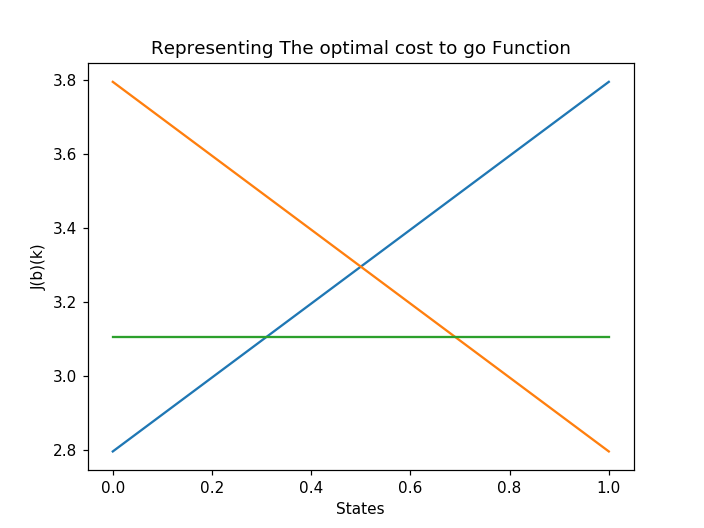

The blue line represents the action guessAC
 The orange line represents the action guessAD
 The green line represents the action peek

  In the x axis we have the beliefs represented in a vector from 0 to 1, 0=AC and 1=AD
  In the y axis we have the optimal cost to go given in the alpha-vectors
  The optimal action for each belief in the range from 0 to 1 is given by 
 the lower envelope in the picewise linear and concave in the plot above
  As we can see, there is a range of beliefs where the action peek will be chosen. 
 As we saw in the previous activity with the MLS and AV heuristics, the action peek was never 
 chosen. So we can conclude that these heuristics (AV and MLS) are not the optimal.
  In the Q-MDP heuristic there is some chance of choosing the action 'peek'.


In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
 
plt.figure()
plt.plot([2.795, 3.795])
plt.plot([3.795, 2.795])
plt.plot([3.105, 3.105])
plt.xlabel("States")
plt.ylabel("J(b)(k)")
plt.title("Representing The optimal cost to go Function")
 
 
print("The blue line represents the action guessAC\n",
      "The orange line represents the action guessAD\n",
      "The green line represents the action peek\n")
print("  In the x axis we have the beliefs represented in a vector from 0 to 1, 0=AC and 1=AD")
print("  In the y axis we have the optimal cost to go given in the alpha-vectors")
print("  The optimal action for each belief in the range from 0 to 1 is given by \n",
      "the lower envelope in the picewise linear and concave in the plot above")
print("  As we can see, there is a range of beliefs where the action peek will be chosen. \n",
      "As we saw in the previous activity with the MLS and AV heuristics, the action peek was never \n",
      "chosen. So we can conclude that these heuristics (AV and MLS) are not the optimal.")
print("  In the Q-MDP heuristic there is some chance of choosing the action 'peek'.")